# COM-304 - Communications Project
In this series of Jupyter notebooks, we aim to give you a crash course on the most important digital signal processing (DSP) concepts using common scientific computing Python libraries that you should be familiar with like numpy and scipy.
At the end, you will be able to understand in-depth how the most important GNU Radio blocks work underneath, while avoiding the heavy syntaxic sugar that GNU Radio introduces and integrating your work with the bladeRF using the OsmoSDR library.

----

## 01 - Sampling
This notebook motivates the need to sample a signal appropriately to capture all of its information. We will begin by introducing the sampling process and explore sample rates used by different applications. Then we will investigate the effect of sampling a "continuous" waveform at different sampling frequencies and observe the effects of slow, fast, and reasonable sampling. Finally, the Nyquist sampling theorem will be introduced and the effects of aliasing discussed.

## Table of Contents
* [1. Introduction](#introduction)
* [2. Sampling - How Fast?](#sampling_how_fast)
* [3. Sampling Theorem](#sampling_theorem)
* [4. Aliasing](#aliasing)
---

## 1. Introduction <a class="anchor" id="introduction"></a>
Sampling is traditionally performed by an analogue to digital converter (ADC) and can be thought of as recording the voltage level of an analogue signal at an instant in time. This sample is assigned a binary number through a process called quantisation - more on that later. By collecting samples at a regular period, we can approximate an analogue signal in a digital system. An illustration showing the discrete sampling process is presented in Figure 1.

<figure>
<img src="../img/Analogue_Digital_Signals.png" style="width: 80%;"/>
    <figcaption><b>Figure 1: The discrete sampling process.</b></figcaption>
</figure>

The time between samples is called the sampling period, $t_{s}$. The speed at which an ADC generates binary numbers is called the sampling rate or sampling frequency, $f_{s}$.

$$
f_{s} = 1 / t_{s}
$$

Sampling frequency is quoted in samples per second, or simply as Hertz (Hz). 

Let us begin by importing relevant Python libraries and modules for this notebook.

**When prompted, select the Radioconda Python environment**

In [3]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy.fftpack
import helper_functions as hf

This notebook is written for, and runs on, a digital system. Therefore, we cannot realistically generate a continuous analogue signal. However, for the purposes of this demonstration, we can approximate a continuous signal by creating a one using a high sampling rate.

In the following cell, we will create a "continuous" sine wave of frequency 100 Hz. The formula for generating a sine wave is

$$
y(t) = Asin(2\pi ft + \phi)
$$

where $\phi$ is the phase in radians, $f$ is the waveform's frequency, $t$ is the time, and $A$ is the waveform's amplitude.

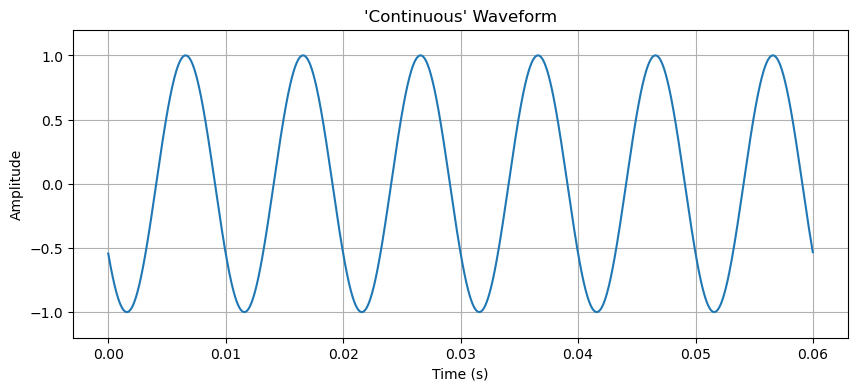

In [4]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

ar = 48000  # A high sample rate to approximate a continuous signal. ar = analogue rate

x_cont = np.arange(0, t, 1/ar)                    # Discrete time i.e. sampled time period
y_cont = A * np.sin(2 * np.pi * f * x_cont + p)   # Formula for sine wave

ax = hf.plot_timeseries("'Continuous' Waveform",
                        [x_cont], [y_cont],
                        ['continuous'])

## 2. Sampling - How Fast? <a class="anchor" id="sampling_how_fast"></a>

We must consider the required **sampling rate** to use so that we can retain **all** of the information in a signal.

Below, we will sample the "continuous" 100 Hz signal at various sampling rates and inspect the results (the red dots constitute the samples)

Sampling at $f_{s}$=100 Hz, which is equivalent to 1 sample per period, gives the following waveform.

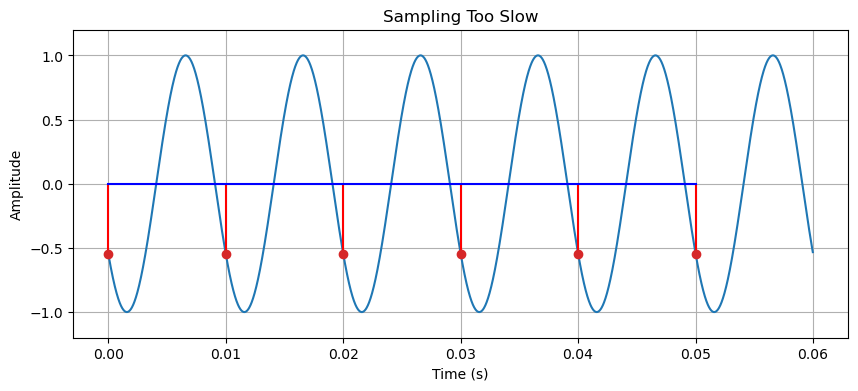

In [5]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

fs = 100    # 100 Hz (1 sample per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + p)    # Formula for sine wave

hf.plot_timeseries("Sampling Too Slow",
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])

The signal here is interpreted as DC with an offset of -0.54 V. 

Sampling at $f_{s}$=80 Hz, which is 1 sample every 0.8 of a period, produces the waveform below.

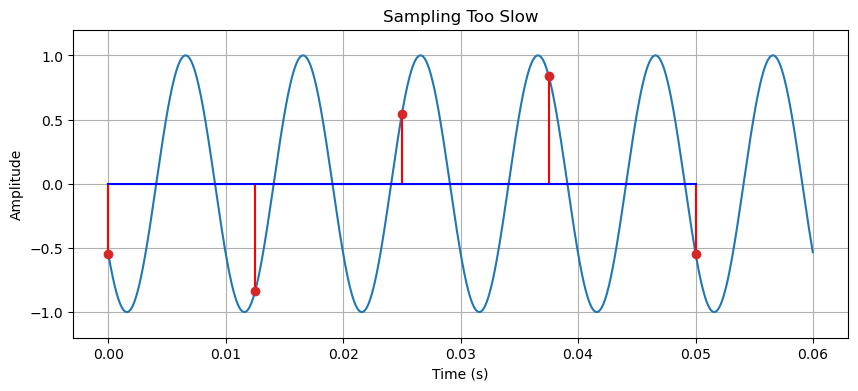

In [6]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

fs = 80    # 80 Hz (1 sample every 0.8 of a period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + p)    # Formula for sine wave

hf.plot_timeseries("Sampling Too Slow",
                   [x_cont, x], [y_cont, y],
                   ['continuous', 'discrete'])

Most of the signal's features are "missed". The sampling rate is too slow to record enough of the information to accurately reconstruct the signal. When the sampling rate is too slow, a sampled signal can be interpreted as having a lower frequency. 

Sampling at $f_{s}$=800 Hz, which is 8 samples per period, results in the following waveform.

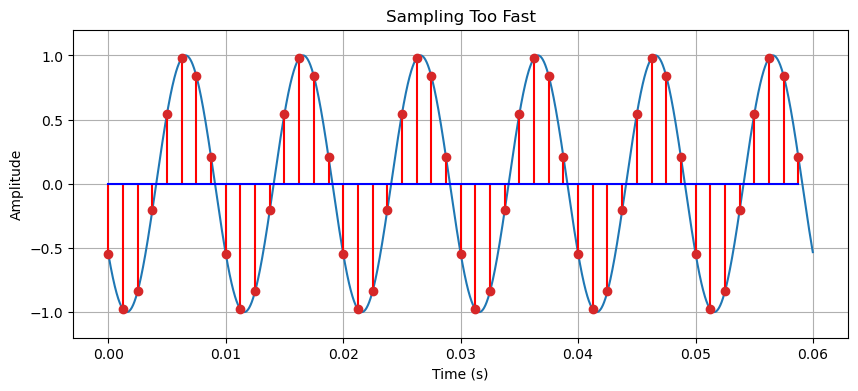

In [7]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

fs = 800    # 800 Hz (8 samples per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + p)    # Formula for sine wave

hf.plot_timeseries("Sampling Too Fast", 
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])

This sample rate appears to be "reasonable".

Finally, sampling at $f_{s}$=3000 Hz, which is equivalent to 30 samples per period, gives us the waveform below.

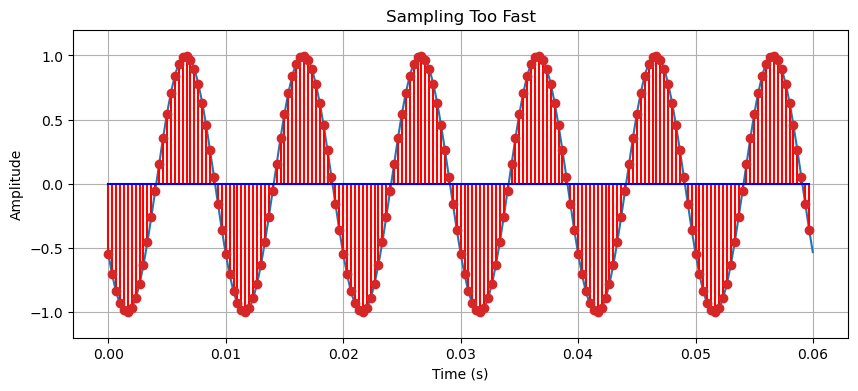

In [8]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

fs = 3000    # 3000 Hz (30 samples per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + p)    # Formula for sine wave

hf.plot_timeseries("Sampling Too Fast", 
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])

Perhaps this rate is higher than necessary.

Sampling too high will improve the approximation of the original signal. However, a higher sample frequency will require more processing and storage.

What is a "suitable" sampling rate?

## 3. Sampling Theorem <a class="anchor" id="sampling_theorem"></a>

From mathematical theory, the minimum sampling rate required to retain all information is referred to as the **Nyquist frequency/rate**, which is denoted as $f_n$. The Nyquist frequency is defined as,

$$
f_{n}\ge 2 f_{max}
$$

where $f_{max}$ is the maximum frequency component of a **baseband** or **bandlimited** signal.

* A baseband signal consists of a set of frequencies that are not modulated. Typically, these frequencies are around 0Hz.
* A bandlimited signal contains frequencies in the range $f_{l}<f<f_h$, where $f_{l}$ is the lowest frequency and $f_h$ is the highest frequency.

An example frequency spectra of a baseband signal and a bandlimited signal is presented in Figure 2.

<figure>
<img src="../img/baseband_bandpass.png" style="width: 75%; vertical-align: middle;"/>
    <figcaption><b>Figure 2: Frequency spectra of a baseband signal.</b></figcaption>
</figure>

Notice that in each of the above cases, it is necessary to sample twice as fast as the highest frequency component in the signal to acquire all of its information.

## 4. Aliasing <a class="anchor" id="aliasing"></a>
When a (baseband) signal is sampled at a frequency below the Nyquist frequency, then we “lose” the signal's information and aliasing is said to have occurred. 

Aliasing can be illustrated by sampling a sine wave below the Nyquist frequency. The sine wave will appear to have a lower frequency.

Consider again, sampling the 100 Hz size wave at 80 Hz.

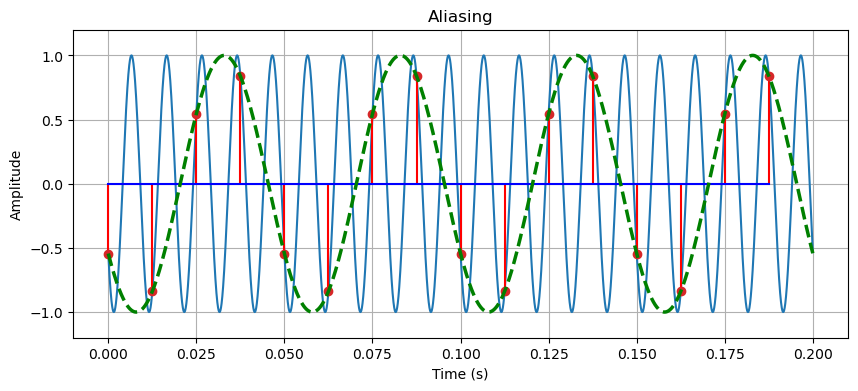

Perceived frequency:  20.0 Hz


In [9]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.2     # Time
p = 10      # Phase

fs = 80     # Sampling frequency 
 
# 'Continuous' waveform
x_cont = np.arange(0, t, 1/ar)                   
y_cont = A * np.sin(2 * np.pi * f * x_cont + p)   

# Sampled waveform
x = np.arange(0, t, 1/fs)               
y = A * np.sin(2 * np.pi * f * x + p)   

# Perceived aliased waveform
f_alias = f-fs*np.round(f/fs)
x_alias = np.arange(0, t, 1/ar)
y_alias = A * np.sin(2 * np.pi * f_alias * x_alias + p)

hf.plot_timeseries("Aliasing",
                   [x_cont, x, x_alias], [y_cont, y, y_alias],
                   ['continuous', 'discrete', 'dash'])
print("Perceived frequency: ", f_alias, "Hz")

Observe that when the sampling rate does not obey the sampling theorem stated above, the perceived waveform is of a lower frequency. In the case of a desired frequency of 100 Hz and a sampling rate of 80 Hz, the perceived signal has a frequency of 

$$
f_{s}-f_{signal} = 100Hz - 80Hz = 20 Hz.
$$

<div class="alert alert-box alert-info">
Try changing the sampling rate and/or desired frequency above and observe the effects on the perceived waveform.
</div>

To better illustrate this concept, we can inspect the frequency domain by running the code cells below.

In [10]:
t = 0.5
fs = 1000

x_cont = np.arange(0, t, 1/ar) # 'Continuous'
x = np.arange(0, t, 1/fs)      # Sampled

A1 = 100
A2 = 1
A3 = 0.01

# Case 1
y1_cont = A1 * np.sin(2 * np.pi * (fs*0.1) * x_cont) \
        + A2 * np.sin(2 * np.pi * (fs*0.25) * x_cont) \
        + A3 * np.sin(2 * np.pi * (fs*0.4) * x_cont)             
y1 = A1 * np.sin(2 * np.pi * (fs*0.1) * x) \
   + A2 * np.sin(2 * np.pi * (fs*0.25) * x) \
   + A3 * np.sin(2 * np.pi * (fs*0.4) * x)

# Case 2
y2_cont = A1 * np.sin(2 * np.pi * (fs*0.9) * x_cont) \
        + A2 * np.sin(2 * np.pi * (fs*0.75) * x_cont) \
        + A3 * np.sin(2 * np.pi * (fs*0.6) * x_cont)
y2 = A1 * np.sin(2 * np.pi * (fs*0.9) * x) \
   + A2 * np.sin(2 * np.pi * (fs*0.75) * x) \
   + A3 * np.sin(2 * np.pi * (fs*0.6) * x)

# Case 3
y3_cont = A1 * np.sin(2 * np.pi * (fs*1.1) * x_cont) \
        + A2 * np.sin(2 * np.pi * (fs*1.25) * x_cont) \
        + A3 * np.sin(2 * np.pi * (fs*1.4) * x_cont)
y3 = A1 * np.sin(2 * np.pi * (fs*1.1) * x) \
   + A2 * np.sin(2 * np.pi * (fs*1.25) * x) \
   + A3 * np.sin(2 * np.pi * (fs*1.4) * x)

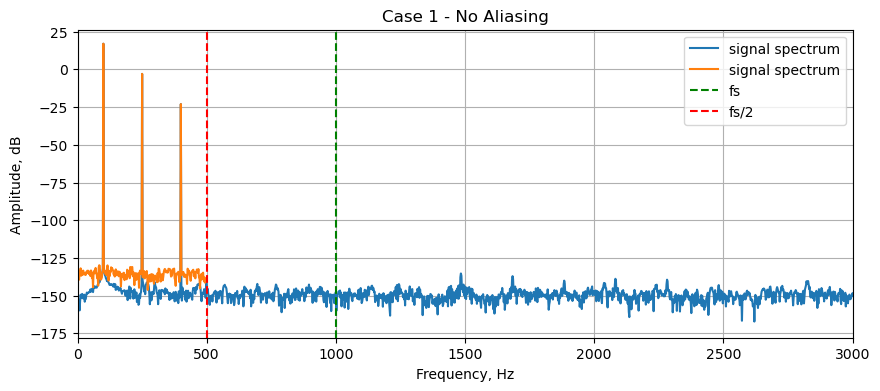

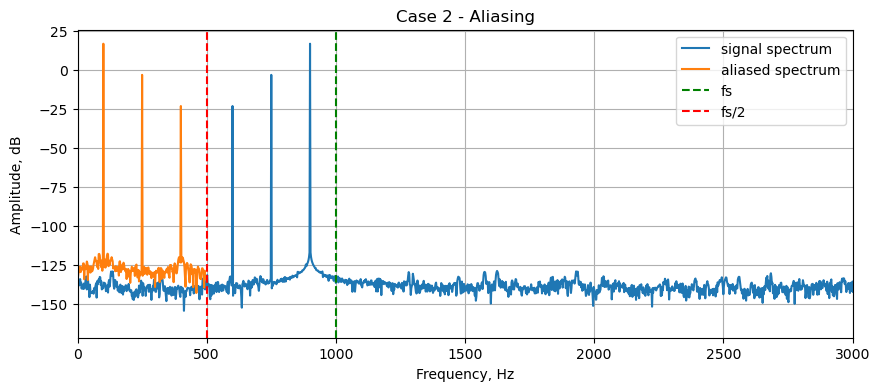

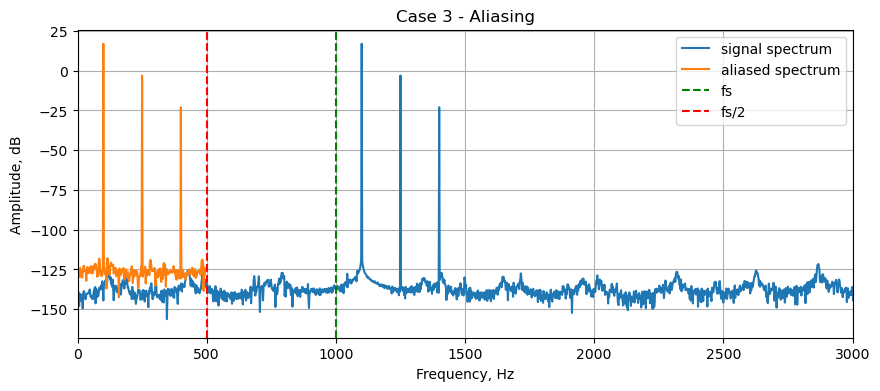

In [11]:
freqs_cont = np.fft.fftshift(np.fft.fftfreq(len(x_cont),1/ar)) #frequency domain axis for graphs
freqs = np.fft.fftshift(np.fft.fftfreq(len(x),1/fs)) #frequency domain axis for graphs

title = "Case 1 - No Aliasing"
fft_cont = hf.find_fft(y1_cont,len(x_cont))
fft_signal = hf.find_fft(y1,len(x))
hf.plot_fft([freqs_cont, freqs], [fft_cont, fft_signal], 
         fs, title, label=['signal spectrum', 'signal spectrum'])

title = "Case 2 - Aliasing"
fft_cont = hf.find_fft(y2_cont,len(x_cont))
fft_signal = hf.find_fft(y2,len(x))
hf.plot_fft([freqs_cont, freqs], [fft_cont, fft_signal], 
         fs, title, label=['signal spectrum', 'aliased spectrum'])

title = "Case 3 - Aliasing"
fft_cont = hf.find_fft(y3_cont,len(x_cont))
fft_signal = hf.find_fft(y3,len(x))
hf.plot_fft([freqs_cont, freqs], [fft_cont, fft_signal],
         fs, title, label=['signal spectrum', 'aliased spectrum'])

* **Case 1 - No Aliasing :** The original signal contains frequencies that are less than $f_s/2$. Therefore, the signal is acquired without losing information using the first Nyquist zone.

* **Case 2 - Aliasing :** The original signal contains frequencies higher than $f_s/2$, but less than $f_s$, which means the frequency components reside in the second Nyquist zone. This condition causes the signal's frequency spectra to fold across $f_s/2$. The frequency components are now considered to be of lower frequency as the original signal has been undersampled.

* **Case 3 - Aliasing :** The original signal now contains frequencies higher than $f_s$, but less than $3f_s/2$, which means the frequency components reside in the third Nyquist zone. This condition causes the signal's frequency spectra to appear at lower frequencies below $f_s/2$ due to undersampling the original signal.

[Next Notebook 🚀](02_quantisation.ipynb)